In [84]:
#IMPORTS
%run ../../TP2/datuslib.ipynb

In [85]:
from sklearn.metrics import f1_score

In [86]:
#SETTINGS
sns.set(rc = {'figure.figsize':(20,10)})
#pd.set_option("display.max_rows", None, "display.max_columns", None)

In [87]:
#CARGA DATA

train = pd.read_csv("../../Data/train.csv")
test = pd.read_csv("../../Data/test.csv")

# Uso de Context como algoritmo de machine learning
    
    Tomamos la clase Context desarrollada durante el TP1 para usar la negatividad que asigna a cada tweet como un clasificador.
    
    Recordando un poco lo que hacia era asigar diferentes pesos a los pares de palabras que aparecian en los tweets en funcion de cuantas veces aparecia dicho par de palabra y en funcion ademas de si los tweets en donde este par de palabra aparecia era desastre o no.
    
    Lo que hacemos es entonces recolectar todos estos pesos y negatividades (tal como se explica en el informe del TP1) sobre el set de train. Posteriormente nos encontramos con que cada tweet tiene asignada un valor no acotado positivo de negatividad. La idea es mapear este valor de negatividad a un intervalo de 0 a 1 de forma tal que el 0.5 corresponda al valor de negatividad n tal que a partir de el para arriba el tweet pueda se clasificado como desastre con suficiente "confianza".
    
    La forma en la que vamos a encontrar ese valor de n es a travez de probar diferentes valores para n y evaluarlos con el score F1. El que mejor de es el que usaremos para el mapeo.
    
    El mapeo se realizara a travez de una sigmoidea que se sabe que sirve para tareas de clasificacion.
    
    Para predecir el target en el set de test se toma el mapa contextual generado con el set de train y el generado con el set de test mismo y se calcula la negatividad contextual de esta forma. Ademas se infiere que la negatividad intrinseca de cada palabra se conserva entre los set de test. Con estas dos negatividades calculadas se calcula la negatividad de cada tweet del set de test (uno sin labels). Posteriormente se mapea esta negatividad a un target tal como se explico lineas arriba.

In [88]:
#Equivalente a hacer train sobre la data
context = Context()

In [89]:
train['negativity'] = context.fit(data = train)

Data loaded
Extracted texts
Extracted Texts Tokens
Tokens processed into cleaned up words and mapped
Contextual map produced
Total and Disaster frequencies calculated for every word
Negativity map produced


# Tuneando hiperparametros de Context

    Concretamente la forma en la que se va a mapear la negatividad a una probabilidad de desastre es asi:
    
    negatividad --(a*neg + b)---> neg escalada ---(sigmoidea)---> (0;1) ---(1 if >= 0.5 else 0) ---> target

    El n del que se habla antes es aca lo que seria el -b ya que este representa un corrimiento horizontal de la funcion sigmoidea.
    
    Se va a empezar a buscar el b optimo con un a = 1 porque se intuye que el b sera mas determinante que el a. Luego se buscara linealmente a para ajustar el resultado. Por esta razon se recurre a un gridsearch personalizado.

In [90]:
#grid search personalizado

a_values = [i/1000 for i in range(2000)] # from 0 to 2 with step 0.001
b_values = [-i/1000 * 20 for i in range(1000)] # from 0 to -20 with step 0.01

f1_max = 0
a_max = a_values[0]
b_max = b_values[0]

a = 1
for b in b_values:
    train_preds = train.negativity.apply(lambda x: mapNegToLabel(x,a,b))
    f1 = f1_score(train.target, train_preds)
    if f1 >= f1_max:
        f1_max = f1
        b_max = b
    
b = b_max
for a in a_values:
    train_preds = train.negativity.apply(lambda x: mapNegToLabel(x,a,b))
    f1 = f1_score(train.target, train_preds)
    if f1 >= f1_max:
        f1_max = f1
        a_max = a

In [91]:
a_max,b_max,f1_max

(1.0, -17.34, 0.6828140214216163)

In [92]:
#predecimos
test['target'] = context.predict(test,a_max,b_max)

In [93]:
#Filtra outliers para mejorar el plot (los 15 mas grandes era mas grandes por mucho)

train_no_out = train.sort_values('negativity').head(-15)

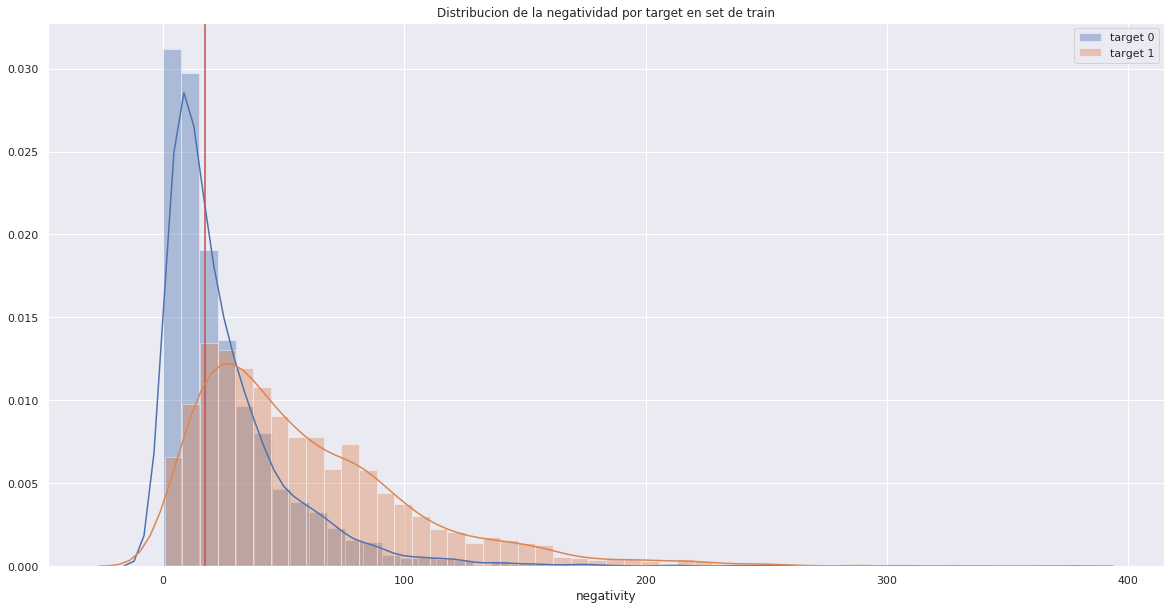

In [94]:
#Visualizando como asigna Context los labels

sns.distplot(train_no_out[ train_no_out.target == 0 ].negativity, label = 'target 0')\
.axvline(-b_max, ls = '-', color = 'r')
sns.distplot(train_no_out[ train_no_out.target == 1 ].negativity, label = 'target 1')\
.set_title('Distribucion de la negatividad por target en set de train')
plt.legend()

# Aclaracion

    La linea roja vertical que se ve en el grafico es el valor de n de negatividad optimo a partir del cual se considera que cualquier tweet de negatividad mayor a el es un desastre. Es interesante notar que en el TP1 se observo que el mejor valor para separar desastre de no desastre parecia andar alrededor de 20 y que aca se vea que es 17.4 aprox 

In [95]:
#test[['id','target']].set_index('id').to_csv('A_Context_prediction.csv')